In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.distributions as td
from data.data_handler import SimpleDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from models.layers import Normal, Latent, MVN
from trainer import Trainer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"

In [3]:
stocks = pd.read_csv(data_dir + "ex_aktier.csv").dropna(how="all").fillna(method="pad").set_index(["Date", "Isin"]).unstack()["Close"]
stocks.index = pd.to_datetime(stocks.index)
stocks = stocks.loc["2010-12-31":"2020-03-31"]
returns = stocks.resample("W-Fri").first().pct_change()
returns[returns == 0.0] = np.nan

X = []
t_list = []

n_x = 30
windows = 100

t = 0
t_dict = {}
for date, row in returns.iterrows():
    t_dict[t] = date
    r = row.dropna()
    if n_x > len(r):
        continue
    for i in range(windows):
        idx = np.random.choice(np.arange(len(r)), n_x, replace=False)
        r_i = r.iloc[idx].clip(-1,1)
        X.append(r_i.values)
        t_list.append([t])
    t = t + 1
X = np.array(X)
t_list = np.array(t_list)
        


In [4]:
X.shape, t_list.shape

((48200, 30), (48200, 1))

In [5]:
t_list

array([[  0],
       [  0],
       [  0],
       ...,
       [481],
       [481],
       [481]])

In [6]:
X_train, X_test, t_train, t_test = train_test_split(X, t_list, test_size=0.2, random_state = 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
train_data = SimpleDataset(torch.from_numpy(X_train), torch.from_numpy(t_train))
test_data = SimpleDataset(torch.from_numpy(X_test), torch.from_numpy(t_test))


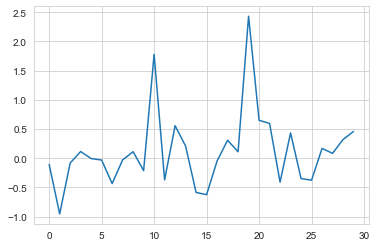

In [8]:
x, t = train_data[2]
_ = plt.plot(x.detach().numpy())

In [9]:
class Dense(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(i, o),
            nn.BatchNorm1d(o),
            nn.ELU()
        )
    
    def forward(self, x):
        return self.l(x)
        

In [10]:
class VAE(nn.Module):
    def __init__(self, n_x, n_z):
        super().__init__()
        
        self.enc = nn.Sequential(
            Dense(n_x, 100),
            Dense(100, 50),
            Latent(50, n_z)
        )
        self.dec = nn.Sequential(
            Dense(n_z, 50),
            Dense(50, 100),
            MVN(100, n_x)
        )
        
        self.mse = nn.SmoothL1Loss(reduction="sum")
    
    def _dkl(self, mu, log_var):
        alpha = 1
        vega =1
        dkl = 0.5 * torch.sum(alpha * mu.pow(2) + log_var.exp() -1 -vega*log_var)
        return dkl
    
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def forward(self, x, beta = 1.0):
        z, mu, log_var = self.encode(x)
        dkl = self._dkl(mu, log_var)
        dist = self.decode(z)
        rcl = -dist.log_prob(x).sum()
        #rcl = self.mse(dist, x)
        loss = torch.mean(rcl + beta*dkl)
        return dist, loss

In [11]:
vae = VAE(n_x, 2)
vae.train()
t = Trainer(vae, train_data, test_data)

In [12]:
losses = t.fit(100, burn_in=10)

Epoch: 0, Train Loss: 44.91, Test Loss:  39.39
Epoch: 10, Train Loss: 34.75, Test Loss:  34.25
Epoch: 20, Train Loss: 37.20, Test Loss:  36.92
Epoch: 30, Train Loss: 37.05, Test Loss:  36.80
Epoch: 40, Train Loss: 36.99, Test Loss:  36.71
Epoch: 50, Train Loss: 36.96, Test Loss:  36.65
Epoch: 60, Train Loss: 36.92, Test Loss:  36.62
Epoch: 70, Train Loss: 36.87, Test Loss:  36.68
Epoch: 80, Train Loss: 36.87, Test Loss:  36.63
Epoch: 90, Train Loss: 36.83, Test Loss:  36.60


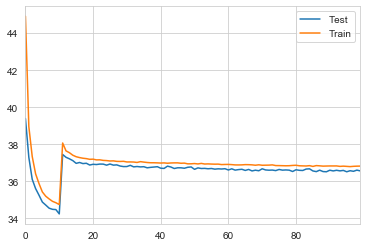

In [13]:
losses.plot()

38560


(tensor([-0.0020, -0.0632], grad_fn=<MeanBackward1>),
 tensor([1.0496, 0.9826], grad_fn=<StdBackward1>))

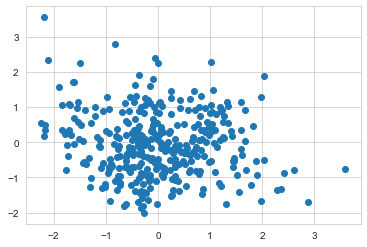

In [14]:
print(len(train_data))
idx = np.random.choice(np.arange(len(train_data)), 350, replace=False)
X, t = train_data[idx]
z, mu, log_var = vae.encode(X)
zz = mu.detach().numpy()
_ = plt.scatter(zz[:,0], zz[:,1])
z.mean(dim=0), z.std(dim=0)

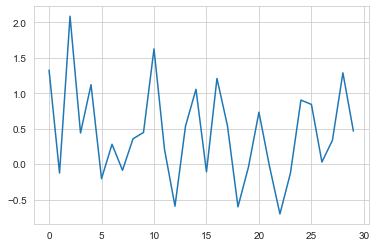

In [15]:
_ = plt.plot(vae.decode(z).sample()[0].detach().numpy())

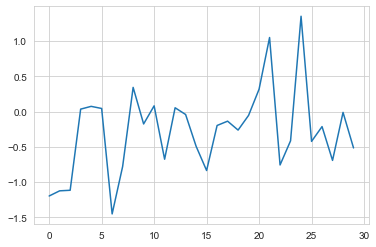

In [16]:
_ = plt.plot(X[0].detach().numpy())